In [126]:
!ls /home/abhirup/Downloads/CMaterdb/IsolatedTrain/
path = '/home/abhirup/Downloads/CMaterdb/CMATERdbTrain/'

1    109  119  129  139  149  159  169	24  34	44  54	64  74	84  94
10   11   12   13   14	 15   16   17	25  35	45  55	65  75	85  95
100  110  120  130  140  150  160  170	26  36	46  56	66  76	86  96
101  111  121  131  141  151  161  171	27  37	47  57	67  77	87  97
102  112  122  132  142  152  162  18	28  38	48  58	68  78	88  98
103  113  123  133  143  153  163  19	29  39	49  59	69  79	89  99
104  114  124  134  144  154  164  2	3   4	5   6	7   8	9
105  115  125  135  145  155  165  20	30  40	50  60	70  80	90
106  116  126  136  146  156  166  21	31  41	51  61	71  81	91
107  117  127  137  147  157  167  22	32  42	52  62	72  82	92
108  118  128  138  148  158  168  23	33  43	53  63	73  83	93


In [2]:
import cv2
import tensorflow as tf
import numpy
import sys, os
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
from sklearn.utils import shuffle
import numpy as np

In [134]:
def load_data(path):
    sub_paths = os.listdir(path)
    img_data = []
    label_data = []
    c = 0
    for sub_path in sub_paths:
        img_paths = os.listdir(path + sub_path)
        for img_path in img_paths:
            img = cv2.imread(path + sub_path + '/' + img_path , 0)
            ret, img = cv2.threshold(img, 245, 1, cv2.THRESH_BINARY)
            if img is None: continue
            img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
            label = int(sub_path)
            img_data.append(img)
            label_data.append(label)
            c = c + 1
    print("No of subfolders %d"%len(sub_paths), "No of images %d"%c)
    img_data = np.expand_dims(np.array(img_data),-1)
    img_data, label_data = shuffle(img_data, label_data, random_state=0)
    return img_data


In [125]:
def load_data2(path):
    sub_paths = os.listdir(path)
    img_data = []
    label_data = []
    c = 0
    for sub_path in sub_paths:
        img_paths = os.listdir(path + sub_path)
        c += len(img_paths)
    print(c)

In [133]:
load_data2('/home/abhirup/Downloads/CMaterdb/WordTrain/')
load_data2('/home/abhirup/Downloads/CMaterdb/IsolatedTrain/')
load_data2('/home/abhirup/Downloads/CMaterdb/CMATERdbTrain/')
load_data2('/home/abhirup/Downloads/CMaterdb/WordTest/')
load_data2('/home/abhirup/Downloads/CMaterdb/IsolatedTest/')
load_data2('/home/abhirup/Downloads/CMaterdb/CMATERdbTest/')

6756
28271
1337
1801
7040
419


In [109]:
train_img= load_data(path)
train_img.shape

No of subfolders 99 No of images 1309


(1309, 32, 32, 1)

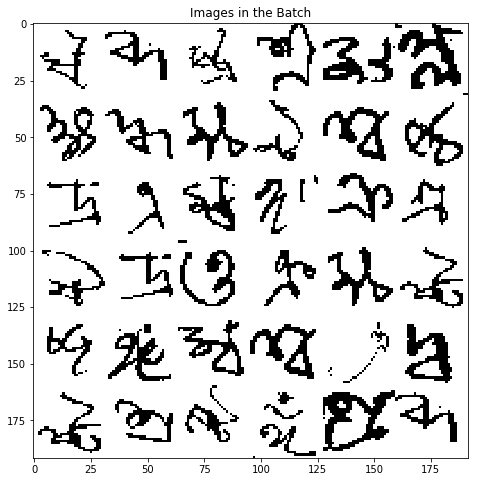

In [105]:
idx = [[2, 5, 6, 26, 77, 102], [88, 98, 100, 0, 101, 993], [33, 44, 20, 21, 24, 52], 
       [12, 33, 45, 69, 100, 200], [23, 54, 92, 101, 103, 221], [200, 1001, 65, 241, 231, 5]]
n = 6
in_canvas = np.empty((n*32, n*32))
for i,id in enumerate(idx):
    x = train_img[id][:,:,:,0]
#     print(x.shape)
    for j in range(n):
        in_canvas[i*32:(i+1)*32, j*32:(j+1)*32] = x[j,:,:]
plt.figure(figsize=(8,8))
plt.imshow(in_canvas/255, cmap='gray')
plt.title('Images in the Batch')
plt.show()

In [110]:
idx = [[2, 5, 6, 26, 77, 102], [88, 98, 100, 0, 101, 993], [33, 44, 20, 21, 24, 52], 
       [12, 33, 45, 69, 100, 200], [23, 54, 92, 101, 103, 221], [200, 1001, 65, 241, 231, 5]]
idx = np.reshape(idx, (len(idx)*len(idx[0])))
batch = train_img[idx]
idx.shape, batch.shape

((36,), (36, 32, 32, 1))

In [107]:
batch.shape

(36, 32, 32, 1)

In [17]:
conv = tf.layers.conv2d
convt = tf.layers.conv2d_transpose
maxpool = tf.layers.max_pooling2d
upsample = tf.image.resize_nearest_neighbor
Relu = tf.nn.relu
lays = tf.contrib.layers

In [139]:
def Autoencoder(input):
    # tf.reset_default_graph()
    net = conv(input, filters=32, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C1_1')
    net = conv(net, filters=32, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C1_2')
    net = conv(net, filters=32, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C1_3')
    net = maxpool(net, pool_size=2, padding='SAME', strides=2, name='M1')

    net = conv(net, filters=64, kernel_size=3, padding='SAME', activation=Relu, strides=1, name='C2_1')
    net = conv(net, filters=64, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C2_2')
    net = conv(net, filters=64, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C2_3')
    net = maxpool(net, pool_size=2, padding='SAME', strides=2, name='M2')

    net = conv(net, filters=64, kernel_size=3, padding='SAME', activation=Relu, strides=1, name='C3_1')
    net = conv(net, filters=64, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C3_2')
    encoded = conv(net, filters=64, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C3_3')

#     net = convt(encoded, filters=32, kernel_size=3, padding='SAME', activation=Relu, strides=2, name='Tr_1')
    net = upsample(net, size=(16,16))
    net = conv(net, filters=32, kernel_size=3, padding='SAME', activation=Relu, strides=1, name='C4_1')
    net = conv(net, filters=32, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C4_2')
    net = conv(net, filters=32, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='C4_3')

    net = upsample(net, size=(32,32))
    decoded = convt(net, filters=1, kernel_size=3, padding='SAME', strides=1, activation=Relu, name='Tr_2')
# def Autoencoder(inputs):
#     # encoder
#     # 32 x 32 x 1   ->  16 x 16 x 32
#     # 16 x 16 x 32  ->  8 x 8 x 16
#     # 8 x 8 x 16    ->  2 x 2 x 8
#     net = lays.conv2d(inputs, 32, [3, 3], stride=2, padding='SAME')
#     print(net)
#     net = lays.conv2d(net, 64, [3, 3], stride=2, padding='SAME')
#     print(net)
#     enc = lays.conv2d(net, 64, [3, 3], stride=2, padding='SAME')
#     print(enc)
#     # decoder
#     # 2 x 2 x 8    ->  8 x 8 x 16
#     # 8 x 8 x 16   ->  16 x 16 x 32
#     # 16 x 16 x 32  ->  32 x 32 x 1
#     net = lays.conv2d_transpose(enc, 64, [3, 3], stride=2, padding='SAME')
#     print(net)
#     net = lays.conv2d_transpose(net, 32, [3, 3], stride=2, padding='SAME')
#     print(net)
#     net = lays.conv2d_transpose(net, 1, [3, 3], stride=2, padding='SAME', activation_fn=tf.nn.tanh)
#     print(net)
    return  decoded


In [140]:
tf.reset_default_graph()
Autoencoder(tf.placeholder(shape=[1, 32,32,1], dtype=tf.float32))

<tf.Tensor 'Tr_2/Relu:0' shape=(1, 32, 32, 1) dtype=float32>

In [146]:
def main(train_data, 
#          no_of_epochs = 150000,
         no_of_epochs = 1,
         batchsize = 6
        ,learning_rate=0.001):
    
    X = tf.placeholder(dtype = tf.float32, shape = [None, 32, 32, 1])
    dec = Autoencoder(X)
#     print(enc, dec)
    loss = tf.reduce_mean(tf.square(dec-X))
#     correct_pred, accuracy = Accuracy_Evaluate(prediction, Label)
    optimiz = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

    init = tf.global_variables_initializer()
    sess.run(init)
    
    tf.summary.scalar('Loss_Value',loss)
    real = tf.summary.image("Input", X, max_outputs=6)
    fake = tf.summary.image("Example", dec, max_outputs=6)
    print('Setting up summary op...')
    summary_op = tf.summary.merge_all()
    print('Setting Up Saver...')
    summary_writer = tf.summary.FileWriter('./log_dir/', sess.graph)
    
    
    num = train_data.shape[0]//batchsize
    itr = 0
    for epoch in range(no_of_epochs):
        in_canv = np.empty((num*32, batchsize*32))
        out_canv = np.empty((num*32, batchsize*32))
        index = np.random.permutation(np.shape(train_data)[0])
        train_data = train_data[index, :, :, :]
        for idx in range(num): 
            
            batchx = train_data[idx*batchsize : (idx + 1)*batchsize , :, :, :]   
            feed_dict = {X : batchx}
            
            
            _, train_loss, summary_str = sess.run([optimiz, loss, summary_op] , feed_dict)
            summary_writer.add_summary(summary_str, itr)
            itr = itr + 1
            
            if idx:
                print ('epoch : '+str(epoch)+' batch : '+str(idx) + ' train_loss : '+str(train_loss))
#         if epoch % 50 == 0:
#         for idx in range(num):
#             batchx = train_data[idx*batchsize : (idx + 1)*batchsize , :, :, :]  
#             feed_dict = {X:batchx}
#             recon = sess.run(dec, feed_dict)
#             for j in range(num):
#                 out_canv[idx*32:(idx+1)*32, j*32:(j+1)*32] = recon[j,:,:,0]
#             print(batchx.shape)
#         batchx
#         plt.figure(figsize=(6,6))
#         plt.imshow(out_canv)
#         plt.show()
                   

In [145]:
tf.trainable_variables()

[<tf.Variable 'C1_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'C1_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'C1_2/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'C1_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'C1_3/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'C1_3/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'C2_1/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'C2_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'C2_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'C2_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'C2_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'C2_3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'C3_1/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'C3_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'C3_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable

In [ ]:
tf.

Setting up summary op...
Setting Up Saver...
epoch : 0 batch : 1 train_loss : 0.854159
epoch : 0 batch : 2 train_loss : 0.750851
epoch : 0 batch : 3 train_loss : 0.669007
epoch : 0 batch : 4 train_loss : 0.375742
epoch : 0 batch : 5 train_loss : 0.94598


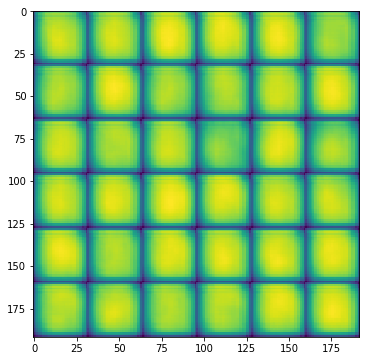

epoch : 1 batch : 1 train_loss : 0.355889
epoch : 1 batch : 2 train_loss : 0.438148
epoch : 1 batch : 3 train_loss : 0.491519
epoch : 1 batch : 4 train_loss : 0.538208
epoch : 1 batch : 5 train_loss : 0.494891


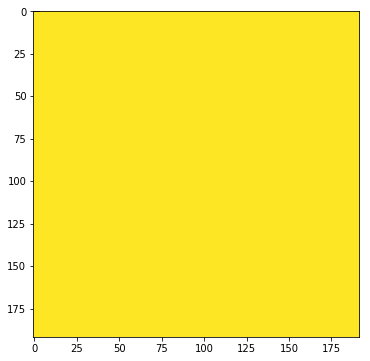

epoch : 2 batch : 1 train_loss : 0.361599
epoch : 2 batch : 2 train_loss : 0.26075
epoch : 2 batch : 3 train_loss : 0.243
epoch : 2 batch : 4 train_loss : 0.391392
epoch : 2 batch : 5 train_loss : 0.259807


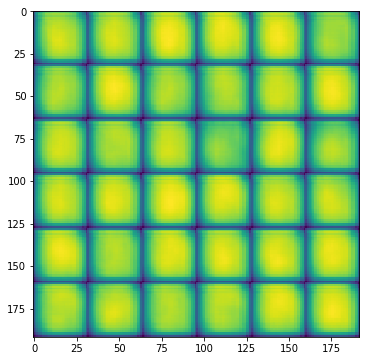

epoch : 3 batch : 1 train_loss : 0.21811
epoch : 3 batch : 2 train_loss : 0.230986
epoch : 3 batch : 3 train_loss : 0.231188
epoch : 3 batch : 4 train_loss : 0.226471
epoch : 3 batch : 5 train_loss : 0.184999


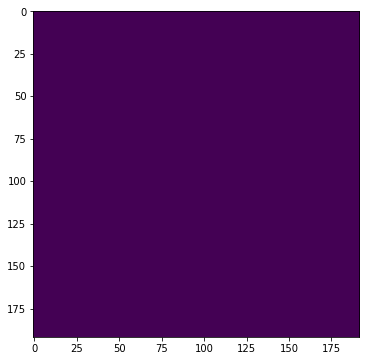

epoch : 4 batch : 1 train_loss : 0.181774
epoch : 4 batch : 2 train_loss : 0.187027
epoch : 4 batch : 3 train_loss : 0.138375
epoch : 4 batch : 4 train_loss : 0.178715
epoch : 4 batch : 5 train_loss : 0.146376


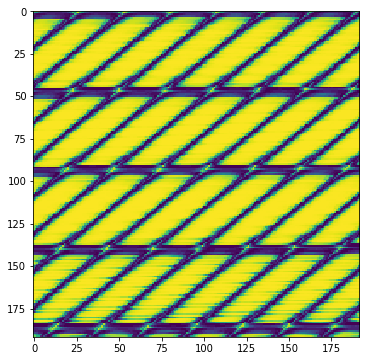

epoch : 5 batch : 1 train_loss : 0.161427
epoch : 5 batch : 2 train_loss : 0.129014
epoch : 5 batch : 3 train_loss : 0.164726
epoch : 5 batch : 4 train_loss : 0.132859
epoch : 5 batch : 5 train_loss : 0.142092


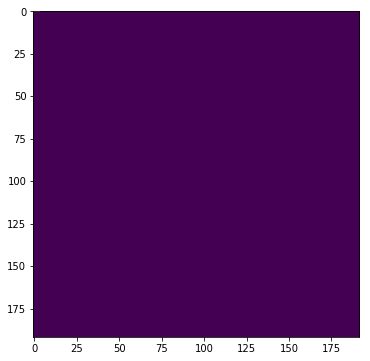

epoch : 6 batch : 1 train_loss : 0.140991
epoch : 6 batch : 2 train_loss : 0.13053
epoch : 6 batch : 3 train_loss : 0.137138
epoch : 6 batch : 4 train_loss : 0.1511
epoch : 6 batch : 5 train_loss : 0.113227


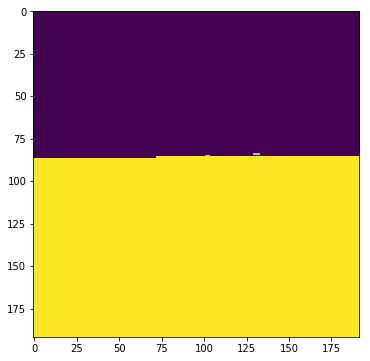

epoch : 7 batch : 1 train_loss : 0.118062
epoch : 7 batch : 2 train_loss : 0.135325
epoch : 7 batch : 3 train_loss : 0.128477
epoch : 7 batch : 4 train_loss : 0.117034
epoch : 7 batch : 5 train_loss : 0.135429


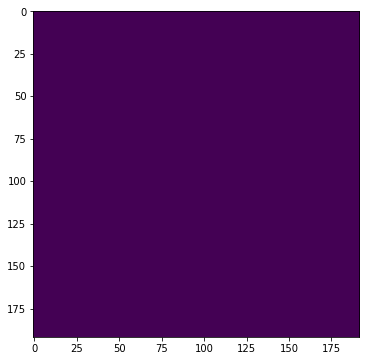

epoch : 8 batch : 1 train_loss : 0.126568
epoch : 8 batch : 2 train_loss : 0.118474
epoch : 8 batch : 3 train_loss : 0.118445
epoch : 8 batch : 4 train_loss : 0.121072
epoch : 8 batch : 5 train_loss : 0.113605


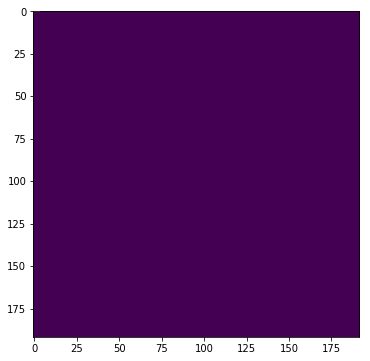

epoch : 9 batch : 1 train_loss : 0.11989
epoch : 9 batch : 2 train_loss : 0.11061
epoch : 9 batch : 3 train_loss : 0.126054
epoch : 9 batch : 4 train_loss : 0.100828
epoch : 9 batch : 5 train_loss : 0.129933


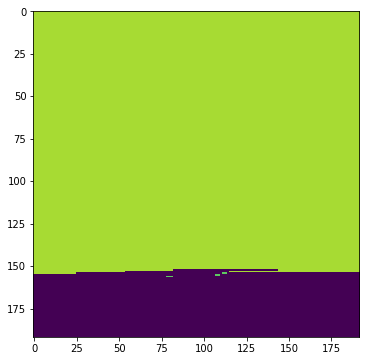

epoch : 10 batch : 1 train_loss : 0.126639
epoch : 10 batch : 2 train_loss : 0.127575
epoch : 10 batch : 3 train_loss : 0.0906759
epoch : 10 batch : 4 train_loss : 0.105425
epoch : 10 batch : 5 train_loss : 0.115482


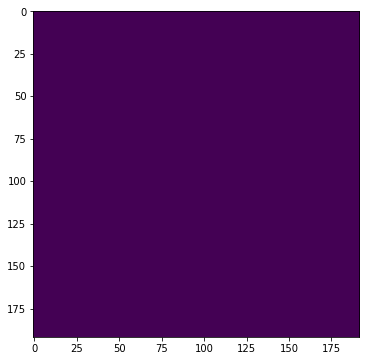

epoch : 11 batch : 1 train_loss : 0.110362
epoch : 11 batch : 2 train_loss : 0.114169
epoch : 11 batch : 3 train_loss : 0.100751
epoch : 11 batch : 4 train_loss : 0.0871384
epoch : 11 batch : 5 train_loss : 0.116631


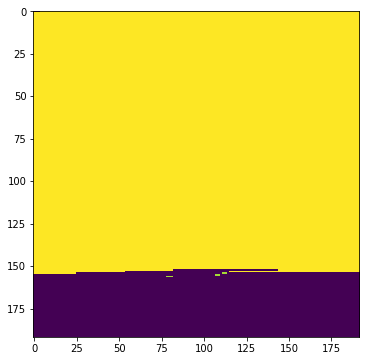

epoch : 12 batch : 1 train_loss : 0.107901
epoch : 12 batch : 2 train_loss : 0.100903
epoch : 12 batch : 3 train_loss : 0.110219
epoch : 12 batch : 4 train_loss : 0.101805
epoch : 12 batch : 5 train_loss : 0.105445


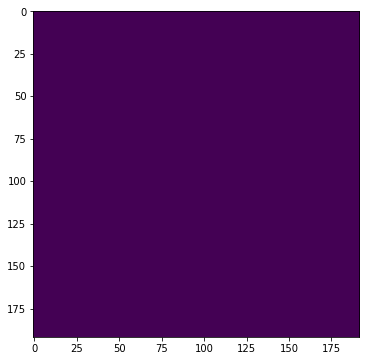

epoch : 13 batch : 1 train_loss : 0.0822359
epoch : 13 batch : 2 train_loss : 0.11608
epoch : 13 batch : 3 train_loss : 0.104418
epoch : 13 batch : 4 train_loss : 0.100014
epoch : 13 batch : 5 train_loss : 0.112506


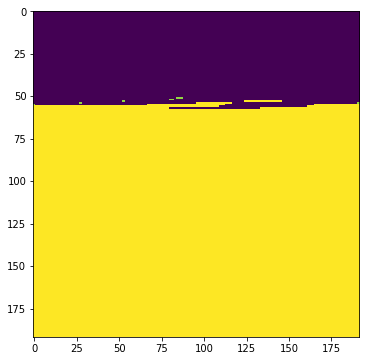

epoch : 14 batch : 1 train_loss : 0.0967978
epoch : 14 batch : 2 train_loss : 0.0840918
epoch : 14 batch : 3 train_loss : 0.106097
epoch : 14 batch : 4 train_loss : 0.0959039
epoch : 14 batch : 5 train_loss : 0.11129


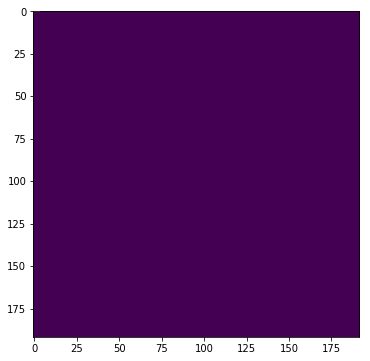

epoch : 15 batch : 1 train_loss : 0.0856669
epoch : 15 batch : 2 train_loss : 0.0832003
epoch : 15 batch : 3 train_loss : 0.106822
epoch : 15 batch : 4 train_loss : 0.0927166
epoch : 15 batch : 5 train_loss : 0.0968335


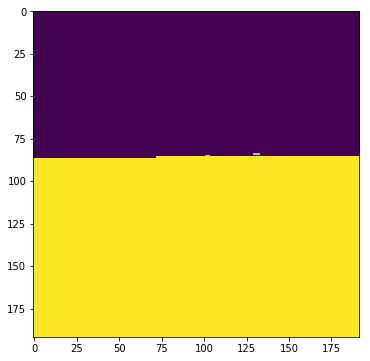

epoch : 16 batch : 1 train_loss : 0.101008
epoch : 16 batch : 2 train_loss : 0.0959292
epoch : 16 batch : 3 train_loss : 0.0867304
epoch : 16 batch : 4 train_loss : 0.0871449
epoch : 16 batch : 5 train_loss : 0.0865504


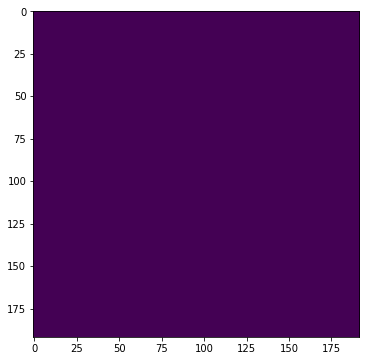

epoch : 17 batch : 1 train_loss : 0.0914585
epoch : 17 batch : 2 train_loss : 0.0751985
epoch : 17 batch : 3 train_loss : 0.0900992
epoch : 17 batch : 4 train_loss : 0.0843536
epoch : 17 batch : 5 train_loss : 0.081913


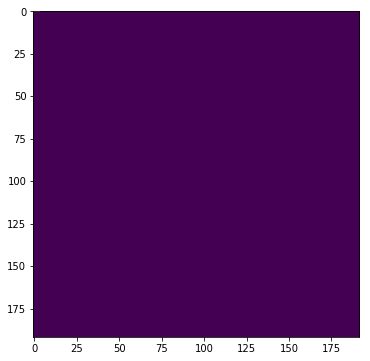

epoch : 18 batch : 1 train_loss : 0.0835336
epoch : 18 batch : 2 train_loss : 0.0899145
epoch : 18 batch : 3 train_loss : 0.0792604
epoch : 18 batch : 4 train_loss : 0.0737014
epoch : 18 batch : 5 train_loss : 0.0896733


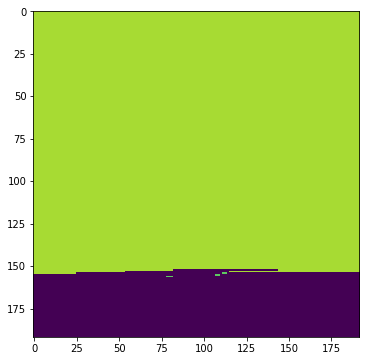

epoch : 19 batch : 1 train_loss : 0.0799519
epoch : 19 batch : 2 train_loss : 0.0823859
epoch : 19 batch : 3 train_loss : 0.0785501
epoch : 19 batch : 4 train_loss : 0.0799034
epoch : 19 batch : 5 train_loss : 0.0685137


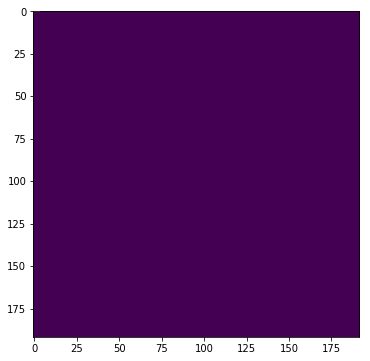

epoch : 20 batch : 1 train_loss : 0.0693868
epoch : 20 batch : 2 train_loss : 0.0741079
epoch : 20 batch : 3 train_loss : 0.0742778
epoch : 20 batch : 4 train_loss : 0.0740635
epoch : 20 batch : 5 train_loss : 0.0863619


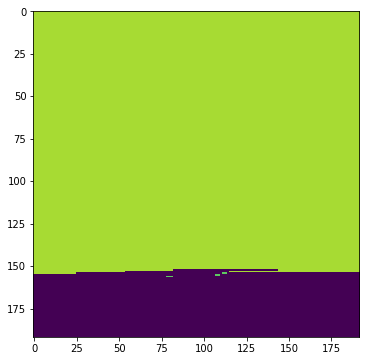

epoch : 21 batch : 1 train_loss : 0.0699676
epoch : 21 batch : 2 train_loss : 0.0746914
epoch : 21 batch : 3 train_loss : 0.0699703
epoch : 21 batch : 4 train_loss : 0.0738987
epoch : 21 batch : 5 train_loss : 0.0731029


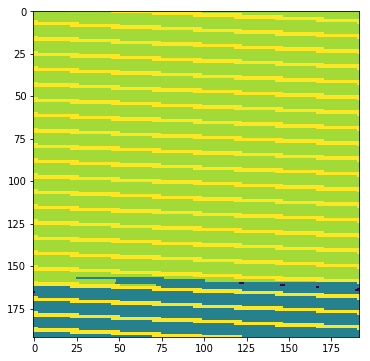

epoch : 22 batch : 1 train_loss : 0.0704161
epoch : 22 batch : 2 train_loss : 0.0731977
epoch : 22 batch : 3 train_loss : 0.0555627
epoch : 22 batch : 4 train_loss : 0.0777521
epoch : 22 batch : 5 train_loss : 0.0666212


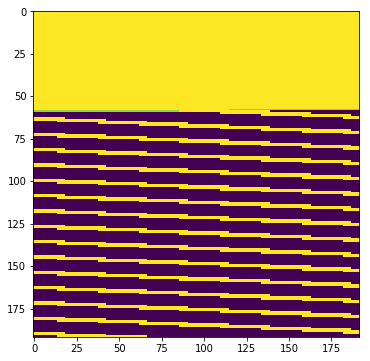

epoch : 23 batch : 1 train_loss : 0.0771014
epoch : 23 batch : 2 train_loss : 0.0700632
epoch : 23 batch : 3 train_loss : 0.0594937
epoch : 23 batch : 4 train_loss : 0.0610219
epoch : 23 batch : 5 train_loss : 0.0592021


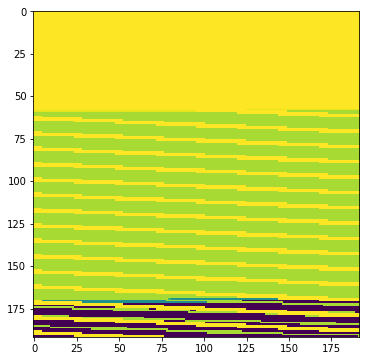

epoch : 24 batch : 1 train_loss : 0.0739302
epoch : 24 batch : 2 train_loss : 0.0672615
epoch : 24 batch : 3 train_loss : 0.0597773
epoch : 24 batch : 4 train_loss : 0.0624055
epoch : 24 batch : 5 train_loss : 0.0613621


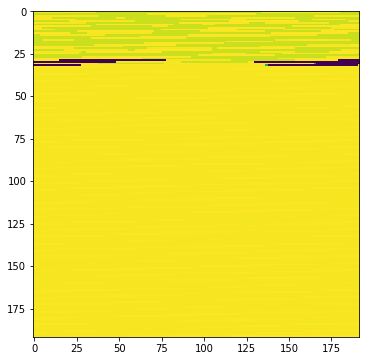

epoch : 25 batch : 1 train_loss : 0.0551417
epoch : 25 batch : 2 train_loss : 0.0696407
epoch : 25 batch : 3 train_loss : 0.0622984
epoch : 25 batch : 4 train_loss : 0.0635065
epoch : 25 batch : 5 train_loss : 0.0569484


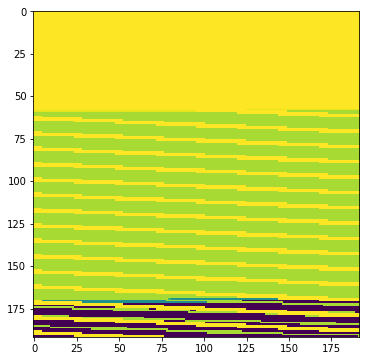

epoch : 26 batch : 1 train_loss : 0.0637211
epoch : 26 batch : 2 train_loss : 0.0612812
epoch : 26 batch : 3 train_loss : 0.0534765
epoch : 26 batch : 4 train_loss : 0.0510438
epoch : 26 batch : 5 train_loss : 0.0601639


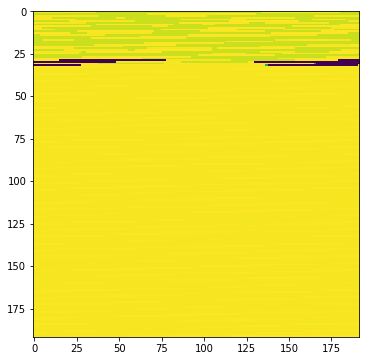

epoch : 27 batch : 1 train_loss : 0.0581709
epoch : 27 batch : 2 train_loss : 0.0601543
epoch : 27 batch : 3 train_loss : 0.0502732
epoch : 27 batch : 4 train_loss : 0.0622038
epoch : 27 batch : 5 train_loss : 0.0539523


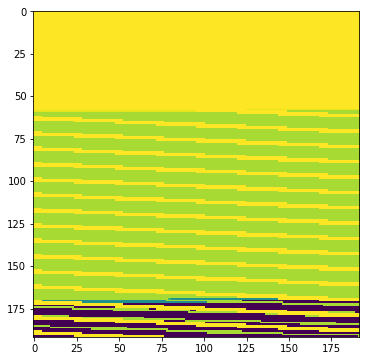

epoch : 28 batch : 1 train_loss : 0.0575083
epoch : 28 batch : 2 train_loss : 0.0541453
epoch : 28 batch : 3 train_loss : 0.0496763
epoch : 28 batch : 4 train_loss : 0.0495802
epoch : 28 batch : 5 train_loss : 0.0575069


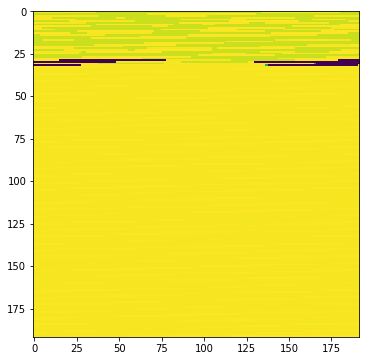

epoch : 29 batch : 1 train_loss : 0.0546963
epoch : 29 batch : 2 train_loss : 0.0541632
epoch : 29 batch : 3 train_loss : 0.0552983
epoch : 29 batch : 4 train_loss : 0.0549849
epoch : 29 batch : 5 train_loss : 0.0590525


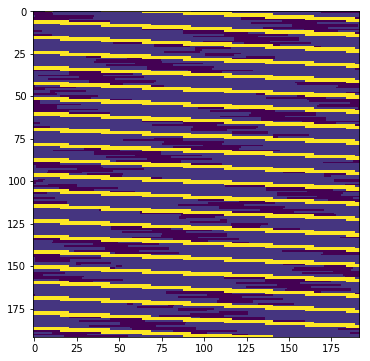

epoch : 30 batch : 1 train_loss : 0.0568039
epoch : 30 batch : 2 train_loss : 0.0504623
epoch : 30 batch : 3 train_loss : 0.0461565
epoch : 30 batch : 4 train_loss : 0.0495692
epoch : 30 batch : 5 train_loss : 0.0501231


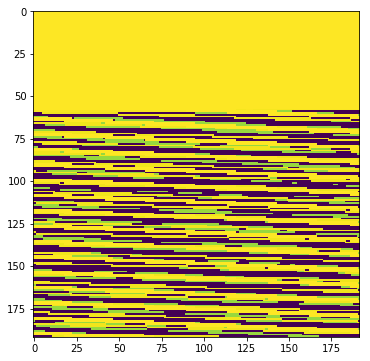

epoch : 31 batch : 1 train_loss : 0.0500003
epoch : 31 batch : 2 train_loss : 0.0430674
epoch : 31 batch : 3 train_loss : 0.0528992
epoch : 31 batch : 4 train_loss : 0.0525817
epoch : 31 batch : 5 train_loss : 0.0489968


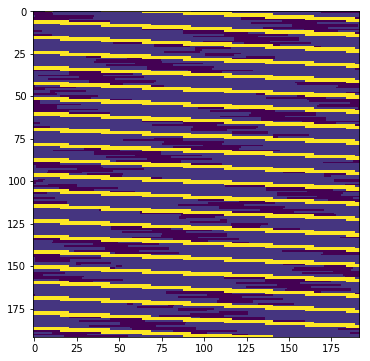

epoch : 32 batch : 1 train_loss : 0.0473744
epoch : 32 batch : 2 train_loss : 0.0490585
epoch : 32 batch : 3 train_loss : 0.0456427
epoch : 32 batch : 4 train_loss : 0.046681
epoch : 32 batch : 5 train_loss : 0.0503509


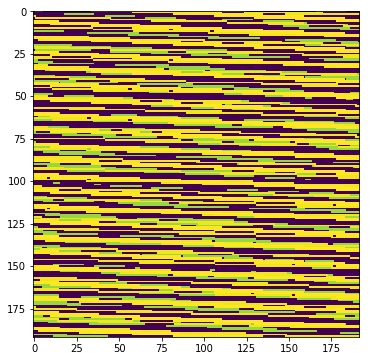

epoch : 33 batch : 1 train_loss : 0.0469036
epoch : 33 batch : 2 train_loss : 0.0481999
epoch : 33 batch : 3 train_loss : 0.0520537
epoch : 33 batch : 4 train_loss : 0.0420287
epoch : 33 batch : 5 train_loss : 0.044966


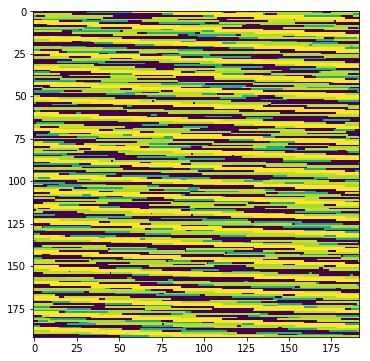

epoch : 34 batch : 1 train_loss : 0.0423547
epoch : 34 batch : 2 train_loss : 0.051314
epoch : 34 batch : 3 train_loss : 0.0494346
epoch : 34 batch : 4 train_loss : 0.0456325
epoch : 34 batch : 5 train_loss : 0.0421247


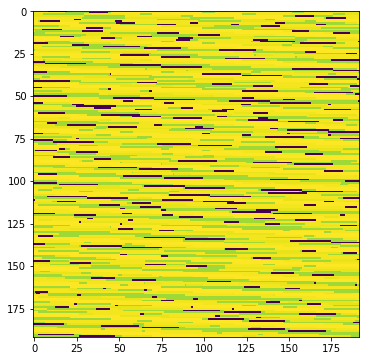

epoch : 35 batch : 1 train_loss : 0.0443986
epoch : 35 batch : 2 train_loss : 0.042613
epoch : 35 batch : 3 train_loss : 0.0466226
epoch : 35 batch : 4 train_loss : 0.0456451
epoch : 35 batch : 5 train_loss : 0.0476986


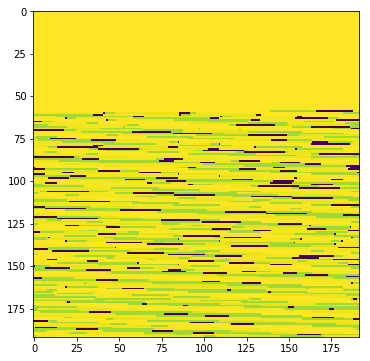

epoch : 36 batch : 1 train_loss : 0.0414382
epoch : 36 batch : 2 train_loss : 0.0487335
epoch : 36 batch : 3 train_loss : 0.0444629
epoch : 36 batch : 4 train_loss : 0.0428439
epoch : 36 batch : 5 train_loss : 0.0405117


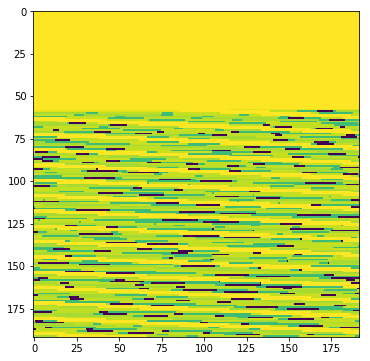

epoch : 37 batch : 1 train_loss : 0.0415937
epoch : 37 batch : 2 train_loss : 0.0442022
epoch : 37 batch : 3 train_loss : 0.0419743
epoch : 37 batch : 4 train_loss : 0.0377001
epoch : 37 batch : 5 train_loss : 0.0387714


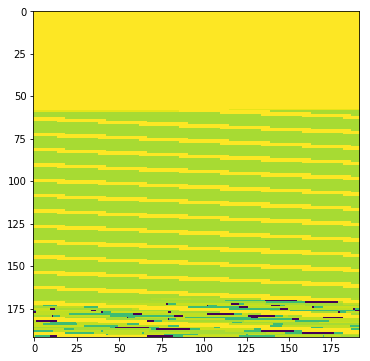

epoch : 38 batch : 1 train_loss : 0.0404304
epoch : 38 batch : 2 train_loss : 0.0407812
epoch : 38 batch : 3 train_loss : 0.0423614
epoch : 38 batch : 4 train_loss : 0.0424155
epoch : 38 batch : 5 train_loss : 0.0379251


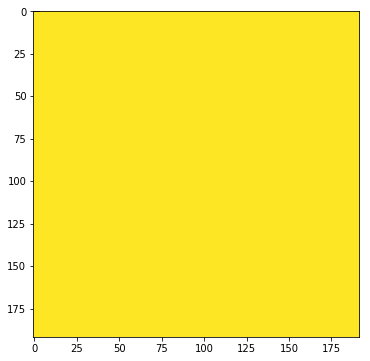

epoch : 39 batch : 1 train_loss : 0.0356136
epoch : 39 batch : 2 train_loss : 0.036596
epoch : 39 batch : 3 train_loss : 0.0429945
epoch : 39 batch : 4 train_loss : 0.0417594
epoch : 39 batch : 5 train_loss : 0.0423126


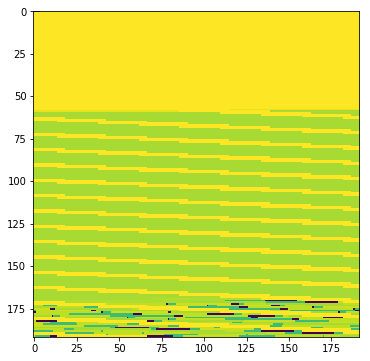

epoch : 40 batch : 1 train_loss : 0.0381625
epoch : 40 batch : 2 train_loss : 0.0431414
epoch : 40 batch : 3 train_loss : 0.0333934
epoch : 40 batch : 4 train_loss : 0.0448494
epoch : 40 batch : 5 train_loss : 0.0407315


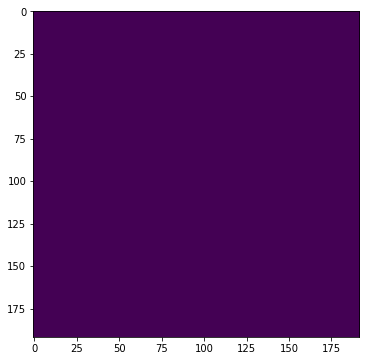

epoch : 41 batch : 1 train_loss : 0.0422654
epoch : 41 batch : 2 train_loss : 0.0334081
epoch : 41 batch : 3 train_loss : 0.0442804
epoch : 41 batch : 4 train_loss : 0.0328394
epoch : 41 batch : 5 train_loss : 0.0407063


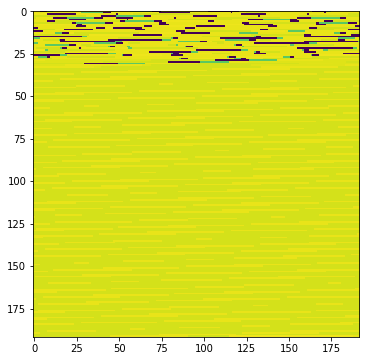

epoch : 42 batch : 1 train_loss : 0.0333836
epoch : 42 batch : 2 train_loss : 0.0386081
epoch : 42 batch : 3 train_loss : 0.0358978
epoch : 42 batch : 4 train_loss : 0.0382023
epoch : 42 batch : 5 train_loss : 0.0396606


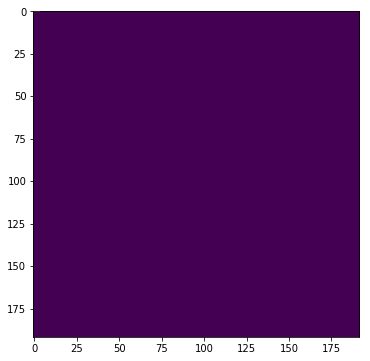

epoch : 43 batch : 1 train_loss : 0.0327845
epoch : 43 batch : 2 train_loss : 0.039449
epoch : 43 batch : 3 train_loss : 0.0416272
epoch : 43 batch : 4 train_loss : 0.0326595
epoch : 43 batch : 5 train_loss : 0.0353593


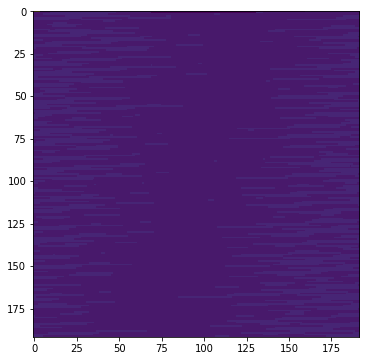

epoch : 44 batch : 1 train_loss : 0.0374948
epoch : 44 batch : 2 train_loss : 0.0351652
epoch : 44 batch : 3 train_loss : 0.0320663
epoch : 44 batch : 4 train_loss : 0.0387333
epoch : 44 batch : 5 train_loss : 0.0309054


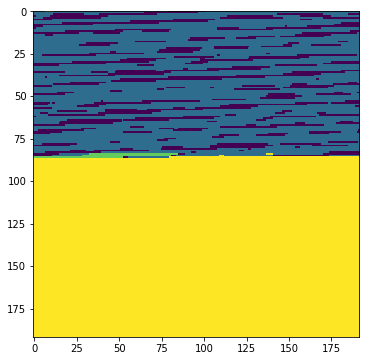

epoch : 45 batch : 1 train_loss : 0.0362133
epoch : 45 batch : 2 train_loss : 0.0368224
epoch : 45 batch : 3 train_loss : 0.0329707
epoch : 45 batch : 4 train_loss : 0.0357547
epoch : 45 batch : 5 train_loss : 0.0406049


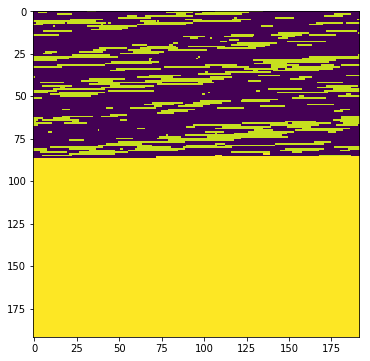

epoch : 46 batch : 1 train_loss : 0.0353952
epoch : 46 batch : 2 train_loss : 0.0365637
epoch : 46 batch : 3 train_loss : 0.0365446
epoch : 46 batch : 4 train_loss : 0.0297582
epoch : 46 batch : 5 train_loss : 0.0365158


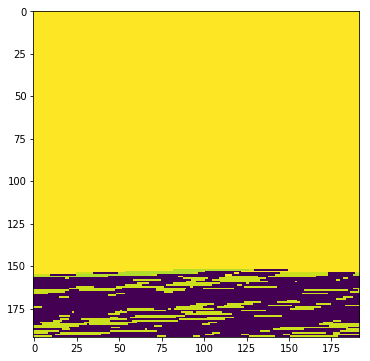

epoch : 47 batch : 1 train_loss : 0.0298809
epoch : 47 batch : 2 train_loss : 0.0353958
epoch : 47 batch : 3 train_loss : 0.0338136
epoch : 47 batch : 4 train_loss : 0.0370155
epoch : 47 batch : 5 train_loss : 0.0348904


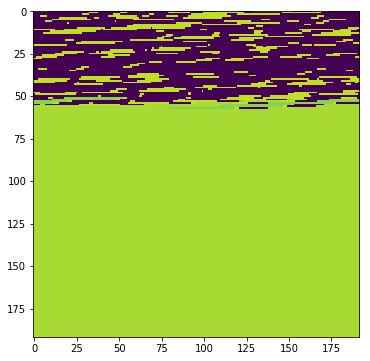

epoch : 48 batch : 1 train_loss : 0.0284137
epoch : 48 batch : 2 train_loss : 0.0366285
epoch : 48 batch : 3 train_loss : 0.0336351
epoch : 48 batch : 4 train_loss : 0.0368555
epoch : 48 batch : 5 train_loss : 0.0356535


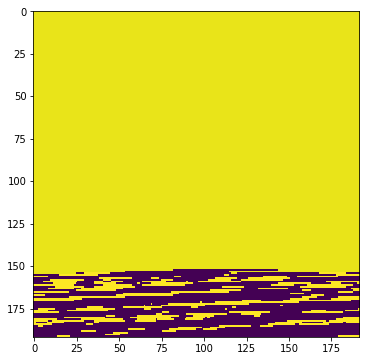

epoch : 49 batch : 1 train_loss : 0.0260126
epoch : 49 batch : 2 train_loss : 0.0291546
epoch : 49 batch : 3 train_loss : 0.034599
epoch : 49 batch : 4 train_loss : 0.0356457
epoch : 49 batch : 5 train_loss : 0.0351191


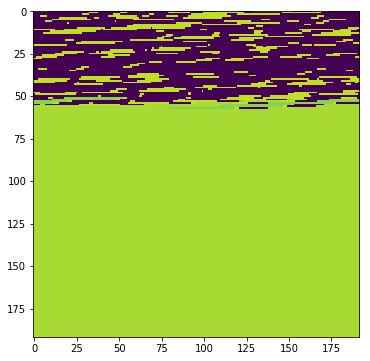

epoch : 50 batch : 1 train_loss : 0.0317047
epoch : 50 batch : 2 train_loss : 0.0317826
epoch : 50 batch : 3 train_loss : 0.036653
epoch : 50 batch : 4 train_loss : 0.0291749
epoch : 50 batch : 5 train_loss : 0.0266695


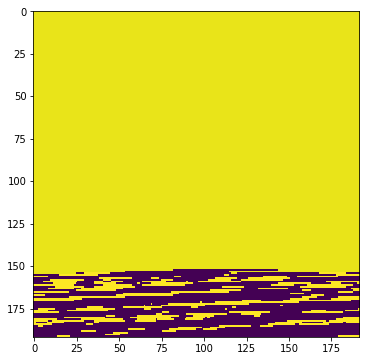

epoch : 51 batch : 1 train_loss : 0.030351
epoch : 51 batch : 2 train_loss : 0.0332341
epoch : 51 batch : 3 train_loss : 0.0325119
epoch : 51 batch : 4 train_loss : 0.0250215
epoch : 51 batch : 5 train_loss : 0.0339949


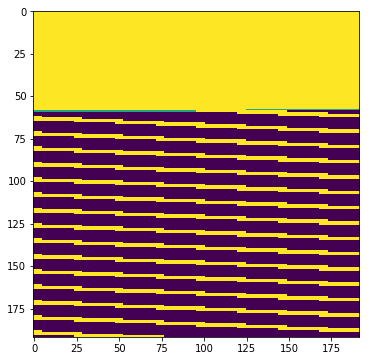

epoch : 52 batch : 1 train_loss : 0.0280953
epoch : 52 batch : 2 train_loss : 0.0324862
epoch : 52 batch : 3 train_loss : 0.0335202
epoch : 52 batch : 4 train_loss : 0.0325172
epoch : 52 batch : 5 train_loss : 0.0290499


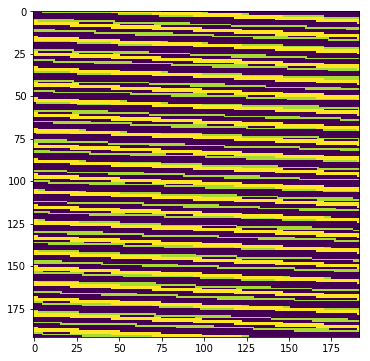

epoch : 53 batch : 1 train_loss : 0.0332936
epoch : 53 batch : 2 train_loss : 0.0360899
epoch : 53 batch : 3 train_loss : 0.0268053


KeyboardInterrupt: 

In [143]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
global sess

config = tf.ConfigProto()
sess = tf.Session(config = config)
graph = tf.get_default_graph()

main(batch, no_of_epochs=1000, learning_rate=0.0009)